# Calculating Weights and Backtesting
Weights are calculated as of today 12/9/2021 and are non adjusting; weights do not change during backtesting.

In [162]:
import pandas_datareader.data as reader
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

end = dt.datetime.now()
start = dt.date(2021, 9, 27)
### ^^ historical data only goes back 9/27/21

## Filling different tiers of the index with constiuents:
See https://rutgers-blockchain-developers.gitbook.io/welcome/projects/rutgers-cross-chain-cryptocurrency-index for more information on the index, tiers, and methodology.

In [163]:
tier_1 = ['DOT1-USD',
          'ATOM1-USD',
          'ONE2-USD',
          'KSM-USD',
          'CKB-USD',
          'RUNE-USD',
          'MATIC-USD']

tier_2 = ['LUNA1-USD',
          'SOL1-USD',
          'ADA-USD',
          'AVAX-USD',
          'TRX-USD',
          'FTM-USD',
          'EGLD-USD',
          'ICP1-USD',
          'VET-USD',
          'ALGO-USD',
          'ROSE-USD',
          'EOS-USD',
          'QTUM-USD',
          'XTZ-USD',
          'HBAR-USD',
          'ONT-USD',
          'ZEN-USD',
          'STX1-USD',
          'CELO-USD',]

tier_3 = ['BTC-USD',
          'ETH-USD']

df1 = reader.get_data_yahoo(tier_1, start, end)['Adj Close']

df2 = reader.get_data_yahoo(tier_2, start, end)['Adj Close']

df3 = reader.get_data_yahoo(tier_3, start, end)['Adj Close']

## Calculating the list of market caps of each tier

In [164]:
### Tier 1
tier1_mc = []
for j in range(len(tier_1)):
    tier1_mc.append(reader.get_quote_yahoo(tier_1)['marketCap'][j])

In [165]:
### Tier 2
tier2_mc = []
for j in range(len(tier_2)):
    tier2_mc.append(reader.get_quote_yahoo(tier_2)['marketCap'][j])

In [166]:
### Tier 3
tier3_mc = []
for j in range(len(tier_3)):
    tier3_mc.append(reader.get_quote_yahoo(tier_3)['marketCap'][j])

## Weightings of Consituents within each Tier, Capped

In [167]:
def reweighting_function(weight_list, cap, index_list_of_nonzeroes_undercap):
    """
    reweighting_function outputs a list of weights that all fit the max cap
    :param weight_list: a list of weights, most likely not fitting the cap
    :param cap: max weight of any 1 constituent
    :param index_list_of_nonzeroes_undercap: ordered list of the indexes of non-zero weights
    :return: a list of weights that fit the cap
    """

    ### Obtaining the excess value, amount of weight thats over the cap, to be distributed to other constituents
    temp_excess_val = 0
    for i in range(len(weight_list)):
        if(weight_list[i] > cap):
            temp_excess_val += weight_list[i] - cap
            weight_list[i] = cap

    ### Obtaining the cumulative value of weights between 0 and the cap
    temp_mc = 0
    for i in index_list_of_nonzeroes_undercap:
        temp_mc += weight_list[i]

    ### Allocating the excess value over the cap to constituent weights between 0 and the cap
    for i in index_list_of_nonzeroes_undercap:
        mc_adj_extra_weight = (weight_list[i] / temp_mc) * temp_excess_val
        weight_list[i] = weight_list[i] + mc_adj_extra_weight
        
    ### Get the indexes of nonzero below-cap weights
    non0_undercap_list_index = []
    for i in range(len(weight_list)):
            if(cap > weight_list[i] > 0):
                non0_undercap_list_index.append(i)
    
    ### Recursive part keeps running function until weights all fit
    for i in range(len(weight_list)):
        if(weight_list[i] > cap):
            reweighting_function(weight_list, cap, non0_undercap_list_index)
            break

    return(weight_list)

In [168]:
def weighting_function(marketcaps, cap):  
    """
    weighting_function outputs a list of appropriate weights accounting for caps
    :param marketcaps: a list of marketcaps
    :param cap: max weight of any 1 constituent
    :return: a list of weights
    """
    total_marketcap = 0
    
    ### Add all market caps
    for i in range(len(marketcaps)):
        total_marketcap += marketcaps[i]
    
    ### If marketcaps list is all 0s, return all those 0s as weights
    if(total_marketcap == 0):
        return(marketcaps)
    
    ### First iteration of weighting
    weight_list = []
    for i in range(len(marketcaps)):
        temp_weight = marketcaps[i] / total_marketcap
        weight_list.append(temp_weight)

    ### Get the indexes of nonzero weights
    non0_list_index = []
    for i in range(len(weight_list)):
            if(weight_list[i] > 0):
                non0_list_index.append(i)
    
    ### Get the indexes of nonzero below-cap weights
    non0_undercap_list_index = []
    for i in range(len(weight_list)):
            if(cap > weight_list[i] > 0):
                non0_undercap_list_index.append(i)
    
    ### If number of nonzero marketcaps (or weights) is too small to fit under cap, assigns most equal weights
    if(1 / np.count_nonzero(weight_list) > cap):
        for i in range(len(weight_list)):
            if(i in non0_list_index):
                weight_list[i] = 1 / np.count_nonzero(weight_list)
            else:
                weight_list[i] = 0
        return(weight_list)
    ### Run recursive rewighting function
    weight_list = reweighting_function(weight_list, cap, non0_undercap_list_index)
    
    return(weight_list)
    
    

In [169]:
### weights are in order of tier_1, _2, _3
df1_weights = weighting_function(tier1_mc, 0.2)
df2_weights = weighting_function(tier2_mc, 0.15)
df3_weights = weighting_function(tier3_mc, 0)



print("Tier1 Weights (within tier): ")
for j in range(len(tier_1)):
    print(tier_1[j] + ": " + str(df1_weights[j] * 100) + ' %')

    
print('\n' + "Tier2 Weights (within tier): ")
for j in range(len(tier_2)):
    print(tier_2[j] + ": " + str(df2_weights[j] * 100) + ' %')

    
print('\n' + "Tier3 Weights (within tier): ")
for j in range(len(tier_3)):
    print(tier_3[j] + ": " + str(df3_weights[j] * 100) + ' %')


    

Tier1 Weights (within tier): 
DOT1-USD: 20.0 %
ATOM1-USD: 20.0 %
ONE2-USD: 12.072097109430477 %
KSM-USD: 14.390324054644044 %
CKB-USD: 3.575633073362146 %
RUNE-USD: 9.961945762563335 %
MATIC-USD: 20.0 %

Tier2 Weights (within tier): 
LUNA1-USD: 15.0 %
SOL1-USD: 15.0 %
ADA-USD: 15.0 %
AVAX-USD: 14.750841766467945 %
TRX-USD: 6.59091300409787 %
FTM-USD: 2.482766556360576 %
EGLD-USD: 3.5472666024150596 %
ICP1-USD: 3.6423454068624053 %
VET-USD: 3.7830402547326667 %
ALGO-USD: 6.490603225846968 %
ROSE-USD: 0.777928124111426 %
EOS-USD: 2.4128670833537726 %
QTUM-USD: 0.6747361866468374 %
XTZ-USD: 2.9767529819427443 %
HBAR-USD: 3.0807002388430162 %
ONT-USD: 0.43829377970257216 %
ZEN-USD: 0.5364632503697842 %
STX1-USD: 1.8522782597457588 %
CELO-USD: 0.9622032785005878 %

Tier3 Weights (within tier): 
BTC-USD: 50.0 %
ETH-USD: 50.0 %


## Function to backtest each Tier
This function uses a static market cap on historical data; NOT a changing one over time; this current function also does not cap weights, TBD.

In [170]:
### Market-Cap Weighted

def backtesting_data(df, ticker_list, weight_list):  
    """
    backtesting_data calculates value of a portfolio

    :param df: dataframe of historical data
    :param ticker_list: list of tickers, same number of columns as df
    :param weight_list: list of weights, same number of columns as df
    :return: value of portfolio
    """
    value = 0
    for i in range(len(ticker_list)):
        value += df[ticker_list[i]] * weight_list[i]
        
    return(value)

## Creating empty dataframe and putting three tier's values into it

In [171]:
df_final = pd.DataFrame()
df_final['Tier1 Value'] = backtesting_data(df1, tier_1, df1_weights)
df_final['Tier2 Value'] = backtesting_data(df2, tier_2, df2_weights)
df_final['Tier3 Value'] = backtesting_data(df3, tier_3, df3_weights)
print(df_final)

            Tier1 Value  Tier2 Value   Tier3 Value
Date                                              
2021-09-27    59.381462    46.194423  22584.934692
2021-09-28    58.698434    43.544166  21920.919800
2021-09-29    59.641456    45.147511  22208.753296
2021-09-30    61.562616    47.172457  23396.286743
2021-10-01    65.199083    51.731280  25712.228760
...                 ...          ...           ...
2021-12-10    51.508279    57.369004  25575.900391
2021-12-11    54.169252    58.718118  26723.480103
2021-12-12    55.790365    59.760759  27116.394531
2021-12-13    49.881266    53.055674  25260.853638
2021-12-14    50.087479    53.387591  25460.208374

[79 rows x 3 columns]


## Set the weights of each tier, calculate value of index daily in dataframe df_final under Index Value

In [172]:
### Set the weights of each tier
t1_weight = 0.5
t2_weight = 0.4
t3_weight = 0.1

df_final['Index Value'] = df_final['Tier1 Value'] * t1_weight + df_final['Tier2 Value'] * t2_weight + df_final['Tier3 Value'] * t3_weight
print(df_final)

            Tier1 Value  Tier2 Value   Tier3 Value  Index Value
Date                                                           
2021-09-27    59.381462    46.194423  22584.934692  2306.661969
2021-09-28    58.698434    43.544166  21920.919800  2238.858863
2021-09-29    59.641456    45.147511  22208.753296  2268.755062
2021-09-30    61.562616    47.172457  23396.286743  2389.278965
2021-10-01    65.199083    51.731280  25712.228760  2624.514929
...                 ...          ...           ...          ...
2021-12-10    51.508279    57.369004  25575.900391  2606.291780
2021-12-11    54.169252    58.718118  26723.480103  2722.919883
2021-12-12    55.790365    59.760759  27116.394531  2763.438939
2021-12-13    49.881266    53.055674  25260.853638  2572.248266
2021-12-14    50.087479    53.387591  25460.208374  2592.419613

[79 rows x 4 columns]


## Plotting our index against benchmark CMC200

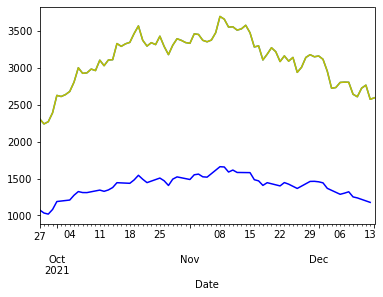

In [173]:
#fig, axs = plt.subplots(2, 2, figsize = (14,8), gridspec_kw = {'hspace': 0.2, 'wspace': 0.1})
df_benchmark = pd.DataFrame()
df_benchmark['^CMC200'] = reader.get_data_yahoo('^CMC200', start, end)['Adj Close']
final_plot = df_final['Index Value'].plot()

plt.plot(df_final['Index Value'], label = 'Index', c='y')
plt.plot(df_benchmark['^CMC200'], label = 'Benchmark', c='b')


# Plotting Cumulative Returns Against Benchmark

In [174]:
df_temp = pd.DataFrame(columns=['Returns'])
df_final = df_final.join(df_temp, how="outer")

df_temp1 = pd.DataFrame(columns=['Returns'])
df_benchmark = df_benchmark.join(df_temp1, how="outer")

### Calculate Daily Returns

In [175]:
for q in range(1, len(df_final)):
    ### (today - yesterday) / yesterday
    df_final['Returns'][q] = (df_final['Index Value'][q] - df_final['Index Value'][q - 1]) / df_final['Index Value'][q - 1]
    
for q in range(1, len(df_benchmark)):
    df_benchmark['Returns'][q] = (df_benchmark['^CMC200'][q] - df_benchmark['^CMC200'][q - 1]) / df_benchmark['^CMC200'][q - 1]


<ipython-input-175-a964f8243d18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Returns'][q] = (df_final['Index Value'][q] - df_final['Index Value'][q - 1]) / df_final['Index Value'][q - 1]
<ipython-input-175-a964f8243d18>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_benchmark['Returns'][q] = (df_benchmark['^CMC200'][q] - df_benchmark['^CMC200'][q - 1]) / df_benchmark['^CMC200'][q - 1]


In [176]:
df_temp = pd.DataFrame(columns=['Real Returns'])
df_final = df_final.join(df_temp, how="outer")

df_temp = pd.DataFrame(columns=['Real Returns'])
df_benchmark = df_benchmark.join(df_temp, how="outer")

### set initial value at inception to 100
df_final['Real Returns'][0] = 100
for i in range(1, len(df_final)):
    df_final['Real Returns'][i] = df_final['Real Returns'][i - 1] * (1 + df_final['Returns'][i])

df_benchmark['Real Returns'][0] = 100
for i in range(1, len(df_benchmark)):
    df_benchmark['Real Returns'][i] = df_benchmark['Real Returns'][i - 1] * (1 + df_benchmark['Returns'][i])

<ipython-input-176-8014f73575e7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Real Returns'][0] = 100
<ipython-input-176-8014f73575e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Real Returns'][i] = df_final['Real Returns'][i - 1] * (1 + df_final['Returns'][i])
<ipython-input-176-8014f73575e7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_benchmark['Real Returns'][0] = 100
<ipython-input-176-8014f73

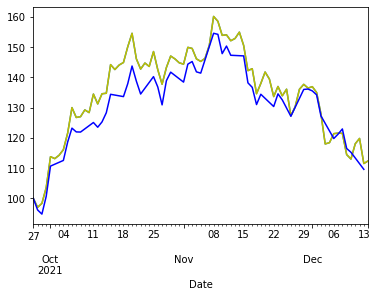

In [177]:
final_plot = df_final['Real Returns'].plot()

plt.plot(df_final['Real Returns'], label = 'Index', c='y')
plt.plot(df_benchmark['Real Returns'], label = 'Benchmark', c='b')